<a href="https://colab.research.google.com/github/AdrianGuel/StochasticProcesses/blob/main/Pendulumwithfriction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install KDEpy
!pip install torchsde

     |████████████████████████████████| 420 kB 8.8 MB/s 
     |████████████████████████████████| 59 kB 3.8 MB/s 
     |████████████████████████████████| 193 kB 16.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [39]:
from typing import Sequence
import torchsde
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

class Kramers(object):
    """Stochastic kramers equation
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (0., 1., -2.,-0.5), b: Sequence = (.01, .01)):
        super(Kramers, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2 = torch.split(y, split_size_or_sections=(1, 1), dim=1)
        a11, a12, a21, a22 = self.a

        f1 = a11 *x1+a12*x2
        f2 = a21*torch.sin(x1)+a22*x2
        #f2 = a21*x1+a22*x2
        return torch.cat([f1, f2], dim=1)

    def g(self, t, y):
        x1, x2= torch.split(y, split_size_or_sections=(1, 1), dim=1)
        b1, b2= self.b

        g1 = b1+0.0*x1#x1 * b1
        g2 = b2+0.0*x2#x2 * b2
        return torch.cat([g1, g2], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts, method='srk',adaptive=True)
        return xs

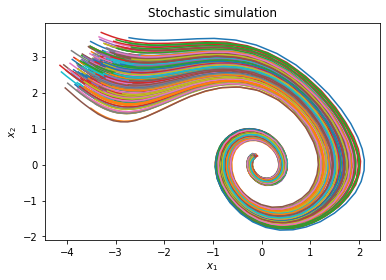

In [57]:
batch_size, state_size, t_size = 10**3, 2, 10**3
tf, noise_std=10,0.1
gpu = torch.device('cuda')
mu0,Sigma0=torch.tensor([-torch.pi,2.6]),0.1*torch.eye(2)
y0=torch.distributions.multivariate_normal.MultivariateNormal(mu0, Sigma0).sample(sample_shape=torch.Size([batch_size]))
y0=y0.to(gpu)
ts = torch.linspace(0, tf, t_size, device='cuda')
xs = Kramers().sample(y0, ts)
x1=xs[:,:,0]
x2=xs[:,:,1]
plt.plot(x1.cpu().detach().numpy(),x2.cpu().detach().numpy())
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Stochastic simulation')
plt.show()

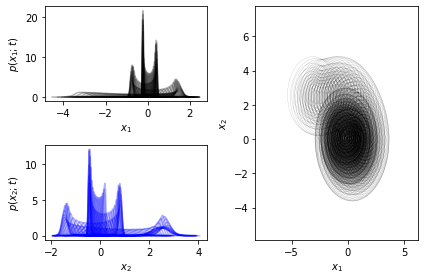

In [58]:
from KDEpy import FFTKDE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
pl.figure()
pl.title('Kernel density estimation')
ax1 = pl.subplot(gs[0, 0])
ax1.set_xlabel('$x_1$') 
ax1.set_ylabel('$p(x_1;t)$') 
ax2 = pl.subplot(gs[1, 0]) 
ax2.set_xlabel('$x_2$') 
ax2.set_ylabel('$p(x_2;t)$') 
ax3 = pl.subplot(gs[:, 1])
ax3.set_xlabel('$x_1$') 
ax3.set_ylabel('$x_2$')  

grid_points = 10**2  # Grid points in each dimension
N = 10  # Number of contours



for i in range(0,t_size,10):
  data=np.array([x1[i,:].cpu().detach().numpy(),x2[i,:].cpu().detach().numpy()])
  kde = FFTKDE(kernel='gaussian', norm=2)
  grid, points = kde.fit(data.T).evaluate(grid_points)
  d_x1,px1 = FFTKDE(kernel='gaussian', bw='silverman').fit(x1[i,:].cpu().detach().numpy()).evaluate(grid_points)
  d_x2,px2 = FFTKDE(kernel='gaussian', bw='silverman').fit(x2[i,:].cpu().detach().numpy()).evaluate(grid_points)
  # The grid is of shape (obs, dims), points are of shape (obs, 1)
  x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
  z = points.reshape(grid_points, grid_points).T
  # Plot the kernel density estimate
  ax1.plot(d_x1,px1, color='k', alpha=0.3)
  ax2.plot(d_x2,px2, color='b', alpha=0.3)
  ax3.contour(x, y, z, N, linewidths=0.1, colors='k', alpha=0.7)
  #ax.contourf(x, y, z, N, cmap="RdBu_r")
  #ax.plot(data[0, :], data[1, :], 'ok', ms=3)
plt.tight_layout()